# Mounting drive



In [1]:
from google.colab import drive
from sys import path

drive.mount('/content/drive', force_remount=True)

root = '/content/drive/My Drive/nlp-lab'
path.append(root)

processed_amazon_data_location = root + '/data/processed-data/amazon'
processed_organic_data_location = root + '/data/processed-data/organic'

Mounted at /content/drive


In [0]:
import numpy as np
import sklearn.metrics as metrics
import pandas as pd

import random
import copy
import json 

import torch
import torch.nn as nn
import torch.utils as utils
from torch import optim

from models.milnet import dataset, model, trainer

%reload_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
def read_data(processed_data_location):
  with open(processed_data_location +
            '/processed_data_without_embeddings_no_outliers.json') as json_file:      
      data_df = json_file.read() 
      data_df = json.loads(data_df)

  return pd.DataFrame(data_df)

amazon_df = read_data(processed_amazon_data_location)
organic_df = read_data(processed_organic_data_location)

In [6]:
organic_df.describe()

,comment_id,sentence_id,number_of_tokens
count,5084.000000,5084.000000,5084.000000
mean,990.261998,7.807632,23.119788
std,559.856430,9.580148,12.618949
min,1.000000,1.000000,3.000000
25%,628.000000,2.000000,14.000000
50%,866.000000,4.000000,21.000000
75%,1568.000000,10.000000,29.000000
max,1921.000000,97.000000,97.000000


In [0]:
comments = []
ratings = []
sentiments = []

sentiment_classes = {'n': 0, '0': 1, 'p': 2}
sentiment_labels = {0 : 'n', 1 : '0', 2 : 'p'}

downsampling_factor = 0.15

for comment_id, comment_df in amazon_df.groupby('comment_id'):
  nunique_ratings = comment_df['comment_rating'].nunique()
  nunique_sentiments = comment_df['comment_sentiment'].nunique()
  if (nunique_ratings > 1 or nunique_sentiments > 1):
    print('Found inconsitent rating or sentiment'
          f'for the comment with id = {comment_id}')
    
  sentiment = comment_df['comment_sentiment'][0]
  if sentiment == 'p' and random.random() > downsampling_factor:
    continue

  comments.append(torch.Tensor(comment_df.loc[:, '0':'767'].values).to(device))
  # We want to have targets in the range [0, C - 1].
  # ratings.append(comment_df['comment_rating'][0] - 1)
  sentiments.append(sentiment_classes[comment_df['comment_sentiment'][0]])

# amazon_rating_dataset = dataset.DocumentDataset(comments, ratings)
amazon_sentiment_dataset = dataset.DocumentDataset(comments, sentiments)
# amazon_ratings = torch.Tensor(ratings).to(device)
amazon_sentiments = torch.Tensor(sentiments).to(device)

organic_embeddings = torch.Tensor(
    organic_df.loc[:, '0':'767'].values).to(device)
organic_sentiments = torch.Tensor(organic_df['sentence_sentiment'].apply(
    lambda sentiment: sentiment_classes[sentiment])).to(device)

In [0]:
n_comments = len(amazon_sentiment_dataset)
n_val = int(0.1 * n_comments)
n_test = int(0.1 * n_comments)
n_train = n_comments - n_val - n_test

train_set, val_set, test_set = utils.data.random_split(amazon_sentiment_dataset,
                                                       (n_train, n_val, n_test))

In [0]:
full_stats = amazon_df.groupby('comment_id')['comment_sentiment'].agg(
    pd.Series.mode).value_counts()
sentiments, counts = amazon_sentiments.unique(return_counts=True, sorted=True)
for sentiment, count in zip(sentiments, counts):
  label = sentiment_labels[sentiment.item()]
  print(f'sentiment "{label}":')
  print(f'\tbefore downsampling -> {full_stats[label]}; '
        f'after downsampling -> {count.item()}')

sentiment "n":
	before downsampling -> 1372; after downsampling -> 1372
sentiment "0":
	before downsampling -> 1533; after downsampling -> 1533
sentiment "p":
	before downsampling -> 12605; after downsampling -> 1951


In [0]:
params = model.MilNetParams()

params.seg_emb_dim =  768
params.seg_hidden_dim = 300
params.hidden_dim = 50
params.gru_layers = 10
params.attention_dim = 100
params.dropout_gru = 0.5
params.dropout_att = 0.5
params.dropout_seg = 0.5
params.classes_nb = 3

prepare_batch = lambda batch: trainer.prepare_batch(batch, device)

milnet = model.MilNet(params, train_embeddings=False).to(device)
train_loader = utils.data.DataLoader(train_set, batch_size=128,
                                     shuffle=True,
                                     collate_fn=prepare_batch,
                                     drop_last=True)
val_loader = utils.data.DataLoader(val_set, batch_size=128,
                                     shuffle=True,
                                     collate_fn=prepare_batch,
                                     drop_last=True)

dataloaders = {'train': train_loader, 'val': val_loader}

optimizer = optim.Adam(milnet.parameters(), lr=5e-3, weight_decay=1e-2)
criterion = nn.NLLLoss()

nb_epochs = 200
patience = 50

train_losses, train_accs, val_losses, val_accs = trainer.fit(milnet, optimizer,
                                                             criterion,
                                                             dataloaders,
                                                             nb_epochs,
                                                             patience)

Epoch   1/200 -> train loss: 9.44e-03, accuracy: 39.71%
Epoch   1/200 -> val loss: 6.47e-03, accuracy: 31.13%
Epoch   2/200 -> train loss: 7.88e-03, accuracy: 47.40%
Epoch   2/200 -> val loss: 6.13e-03, accuracy: 39.18%
Epoch   3/200 -> train loss: 7.70e-03, accuracy: 50.41%
Epoch   3/200 -> val loss: 6.10e-03, accuracy: 34.64%
Epoch   4/200 -> train loss: 7.67e-03, accuracy: 50.72%
Epoch   4/200 -> val loss: 5.87e-03, accuracy: 43.51%
Epoch   5/200 -> train loss: 7.65e-03, accuracy: 51.75%
Epoch   5/200 -> val loss: 6.49e-03, accuracy: 37.32%
Epoch   6/200 -> train loss: 7.70e-03, accuracy: 48.20%
Epoch   6/200 -> val loss: 5.81e-03, accuracy: 38.97%
Epoch   7/200 -> train loss: 7.65e-03, accuracy: 50.31%
Epoch   7/200 -> val loss: 5.78e-03, accuracy: 44.74%
Epoch   8/200 -> train loss: 7.60e-03, accuracy: 50.15%
Epoch   8/200 -> val loss: 5.73e-03, accuracy: 44.95%
Epoch   9/200 -> train loss: 7.47e-03, accuracy: 52.93%
Epoch   9/200 -> val loss: 5.86e-03, accuracy: 46.39%
Epoch  10/

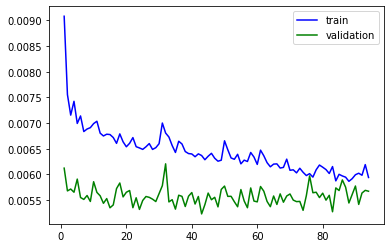

In [0]:
import matplotlib.pyplot as plt

epochs = np.arange(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, color='blue', label='train')
plt.plot(epochs, val_losses, color='green', label='validation')

plt.legend()
plt.show()

In [0]:
torch.save(milnet.state_dict(), root + '/models/milnet/multilingual_sentiment_milnet_state_dict')
# milnet.load_state_dict(torch.load(root + '/models/milnet/rating_milnet_state_dict'))

In [0]:
test_loader = utils.data.DataLoader(test_set, batch_size=n_test,
                                     shuffle=True,
                                     collate_fn=prepare_batch,
                                     drop_last=True)

AMAZON = 'amazon'
ORGANIC = 'organic'
results = {}


milnet.eval()
with torch.set_grad_enabled(False):
  for documents, classes in test_loader:
    predictions = milnet(documents).cpu().numpy()
    results[AMAZON] = (np.argmax(predictions, axis=1), classes.cpu().numpy())
  
  predictions_organic = milnet(tuple(organic_embeddings.unsqueeze(1))).cpu().numpy()
  results[ORGANIC] = (np.argmax(predictions_organic, axis=1), 
                      organic_sentiments.cpu().numpy())

In [0]:
for dataset_name, (top1, labels) in results.items():
  print(f'=== {dataset_name} ===')
  print(f'F1-micro = {metrics.f1_score(labels, top1, average="micro")}')
  print(f'F1-macro = {metrics.f1_score(labels, top1, average="macro")}')
  confusion = metrics.confusion_matrix(labels, top1)
  sentiments = [sentiment_labels[i] for i in range(len(confusion))]
  row_format ="{:>5}" * (len(confusion) + 1)
  print()
  print(row_format.format("", *sentiments))
  for sentiment, row in zip(sentiments, confusion):
    print(row_format.format(sentiment, *row))
  print()

=== amazon ===
F1-micro = 0.5855670103092784
F1-macro = 0.5480620324572375

         n    0    p
    n   70   27   30
    0   47   49   49
    p   25   23  165

=== organic ===
F1-micro = 0.290125885129819
F1-macro = 0.2297063792254008

         n    0    p
    n 1072  384   42
    0 1591  350   32
    p 1234  326   53

